# Non-Ideal Shock Tube Example
## Ignition delay time computations in a high-pressure reflected shock tube reactor
 
In this example we will illustrate how to setup and use a constant volume, adiabatic reactor to simulate reflected shock tube experiments. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure.  The example very explicitly follows the form set in batch_reactor_ignition_delay_NTC.pynb, which does very similar calculations, but with an IdealGasReactor.  All credit is due to the developer of that example.  This example generalizes that work to use a Reactor with no pre-assumed EoS.  One can also run ideal gas phases through this simulation, simply by specifying a cti file with that thermodynamic EoS.

Other than the typical Cantera dependencies, plotting functions require that you have matplotlib installed, and data storing and analysis requires pandas. See https://matplotlib.org/ and http://pandas.pydata.org/index.html, respectively, for additional info.
 
The example here demonstrates the calculations carried out by G. Kogekar, et al., "Impact of non-ideal behavior on ignition delay and chemical kinetics in high-pressure shock tube reactors," Combust. Flame., 2017.

The reflected shock tube reactor is modeled as a constant-volume, adiabatic reactor.  The heat transfer and the work rates are therefore both zero.  With no mass inlets or exits, the 1st law energy balance reduces to:

\begin{equation*}
\frac{dU}{dt} = \dot{Q} - \dot{W} = 0.
\end{equation*}
 
Because of the constant-mass and constant-volume assumptions, the density is also therefore constant:

\begin{equation*}
\frac{d\rho}{dt} = 0.
\end{equation*}

Along with the evolving gas composition, then, the thermodynamic state of the gas is defined by the initial total internal energy $U = mu = m\sum_k\left(Y_ku_k\right)$, where $u_k$ and $Y_k$ are the specific internal energy (kJ/kg) and mass fraction of species $k$, respectively. 

The species mass fractions evolve according to the nety chemical production rates due to homogeneous gas-phase reactions:

\begin{equation*}
\frac{dY_k}{dt} = \frac{W_k}{\rho}\dot{\omega}_k,
\end{equation*}

where $W_k$ is the molecular weight of species $k$ $\left({\rm kg}\,{\rm kmol}^{-3}\right)$, $\rho$ is the (constant) gas-phase density $\left({\rm kg}\,{\rm m^{-3}}\right)$, and $\dot{\omega}_k$ is the net production rate of species $k$ $\left({\rm kmol}\,{\rm m^{-3}}\,{\rm s^{-1}}\right)$.

In [1]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import time

import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.5.0a2


In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True

### Define the gas

In this example we will choose a stoichiometric mixture of n-dodecane and air as the gas. For a representative kinetic model, we use that developed by Wang, Ra, Jia, and Reitz (https://www.erc.wisc.edu/chem_mech/nC12-PAH_mech.zip) by [H.Wang, Y.Ra, M.Jia, R.Reitz, Development of a reduced n-dodecane-PAH mechanism and its application for n-dodecane soot predictions, $Fuel$ 136 (2014) 25–36].

To fun a different model or use a different EoS, simply replace this cti file with a different mechanism file.

In [3]:
gas = ct.Solution('../data/WangMechanismRK.yaml')

### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [4]:
# Define the reactor temperature and pressure:
reactorTemperature = 1000 #Kelvin
reactorPressure = 40.0*101325.0 #Pascals

# Set the state of the gas object:
gas.TP = reactorTemperature, reactorPressure

# Define the fuel, oxidizer and set the stoichiometry:
gas.set_equivalence_ratio(phi=1.0, fuel='c12h26', oxidizer={'o2':1.0, 'n2':3.76})

# Create a reactor object and add it to a reactor network
# In this example, this will be the only reactor in the network
r = ct.Reactor(contents=gas)
reactorNetwork = ct.ReactorNet([r])

# Now compile a list of all variables for which we will store data
stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]

# Use the above list to create a DataFrame
timeHistory = pd.DataFrame(columns=stateVariableNames)

### Define useful functions

In [5]:
def ignitionDelay(df, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    return df[species].idxmax()

In [6]:
# Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimatedIgnitionDelayTime = 0.005
t = 0

counter = 1;
while(t < estimatedIgnitionDelayTime):
    t = reactorNetwork.step()
    if (counter%20 == 0):
        # We will save only every 20th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        timeHistory.loc[t] = reactorNetwork.get_state()
    counter+=1

# We will use the 'oh' species to compute the ignition delay
tau = ignitionDelay(timeHistory, 'oh')

# Toc
t1 = time.time()

print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line
# timeHistory.to_csv("time_history.csv")

Computed Ignition Delay: 4.093e-04 seconds. Took 3.98s to compute


## Plot the result

### Import modules and set plotting defaults

### Figure illustrating the definition of ignition delay

<IPython.core.display.Javascript object>


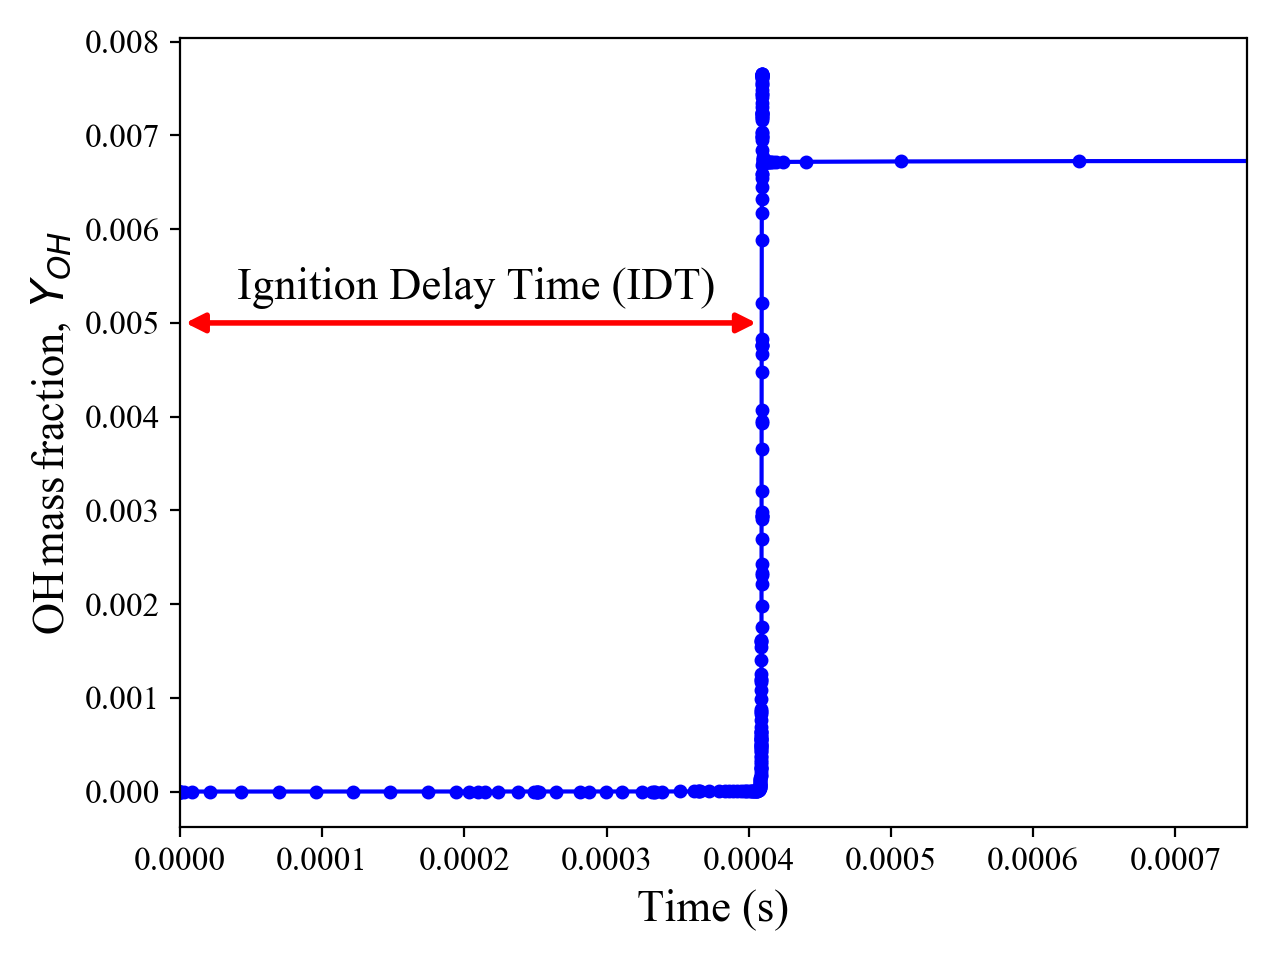

In [7]:
plt.figure()
plt.plot(timeHistory.index, timeHistory['oh'],'-o',color='b',markersize=4)
plt.xlabel('Time (s)',fontname='Times New Roman')
plt.ylabel('$\mathdefault{OH\, mass\, fraction,}\,  Y_{OH}}$',fontname='Times New Roman')

# Figure formatting:
plt.xlim([0,0.00075])
ax = plt.gca()
font = plt.matplotlib.font_manager.FontProperties(family='Times New Roman',size=14)
ax.annotate("",xy=(tau,0.005), xytext=(0,0.005),arrowprops=dict(arrowstyle="<|-|>",color='r',linewidth=2.0),fontsize=14,)
plt.annotate('Ignition Delay Time (IDT)', xy=(0,0), xytext=(0.00004, 0.00525), family='Times New Roman',fontsize=16);

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')

## Illustration : NTC behavior
In the paper by Kogekar, et al., the reactor model is used to demonstrate the impacts of non-ideal behavior on IDTs in the **N**egative **T**emperature **C**oefficient region, where observed IDTs, counter to intuition, increase with increasing temperature.

### Define the temperatures for which we will run the simulations

In [8]:
# Make a list of all the temperatures we would like to run simulations at
T = [1800, 1600, 1400, 1200, 1100, 1075, 1050, 1025, 1000, 975, 950, 925, 900, 850, 825, 800,
     750, 700]

estimatedIgnitionDelayTimes = np.ones(len(T))

# Set the initial guesses to a common value.  We could probably speed up simulations 
# by tuning this guess, but as seen in the figure above, the 'extra' time after igntion 
# does not add many data points or simulation steps.  The time savings would be small.
estimatedIgnitionDelayTimes[:] = 0.005

# Now create a dataFrame out of these
ignitionDelays = pd.DataFrame(data={'T':T})
ignitionDelays['ignDelay'] = np.nan

Run the code above for each temperature, and save the IDT for each.

In [9]:
for i, temperature in enumerate(T):
    # Set up the gas and reactor
    reactorTemperature = temperature
    reactorPressure = 40.0*101325.0
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel='c12h26', oxidizer={'o2':1.0, 'n2':3.76})
    r = ct.Reactor(contents=gas)
    reactorNetwork = ct.ReactorNet([r])

    # Create an empty data frame
    timeHistory = pd.DataFrame(columns=timeHistory.columns)

    t0 = time.time()

    t = 0
    counter = 0
    while t < estimatedIgnitionDelayTimes[i]:
        t = reactorNetwork.step()
        if not counter % 20:
            timeHistory.loc[t] = r.get_state()
        counter += 1

    tau = ignitionDelay(timeHistory, 'oh')
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds for T={}K. Took {:3.2f}s to compute'.format(tau, temperature, t1-t0))

    ignitionDelays.at[i, 'ignDelay'] = tau

Computed Ignition Delay: 6.357e-07 seconds for T=1800K. Took 2.36s to compute
Computed Ignition Delay: 1.585e-06 seconds for T=1600K. Took 2.67s to compute
Computed Ignition Delay: 5.785e-06 seconds for T=1400K. Took 2.71s to compute
Computed Ignition Delay: 3.911e-05 seconds for T=1200K. Took 3.00s to compute
Computed Ignition Delay: 1.326e-04 seconds for T=1100K. Took 3.14s to compute
Computed Ignition Delay: 1.839e-04 seconds for T=1075K. Took 3.32s to compute
Computed Ignition Delay: 2.533e-04 seconds for T=1050K. Took 3.45s to compute
Computed Ignition Delay: 3.365e-04 seconds for T=1025K. Took 3.97s to compute
Computed Ignition Delay: 4.093e-04 seconds for T=1000K. Took 4.06s to compute
Computed Ignition Delay: 4.289e-04 seconds for T=975K. Took 4.01s to compute
Computed Ignition Delay: 3.911e-04 seconds for T=950K. Took 3.94s to compute
Computed Ignition Delay: 3.407e-04 seconds for T=925K. Took 4.10s to compute
Computed Ignition Delay: 3.145e-04 seconds for T=900K. Took 3.74s t

### Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$). 

<IPython.core.display.Javascript object>


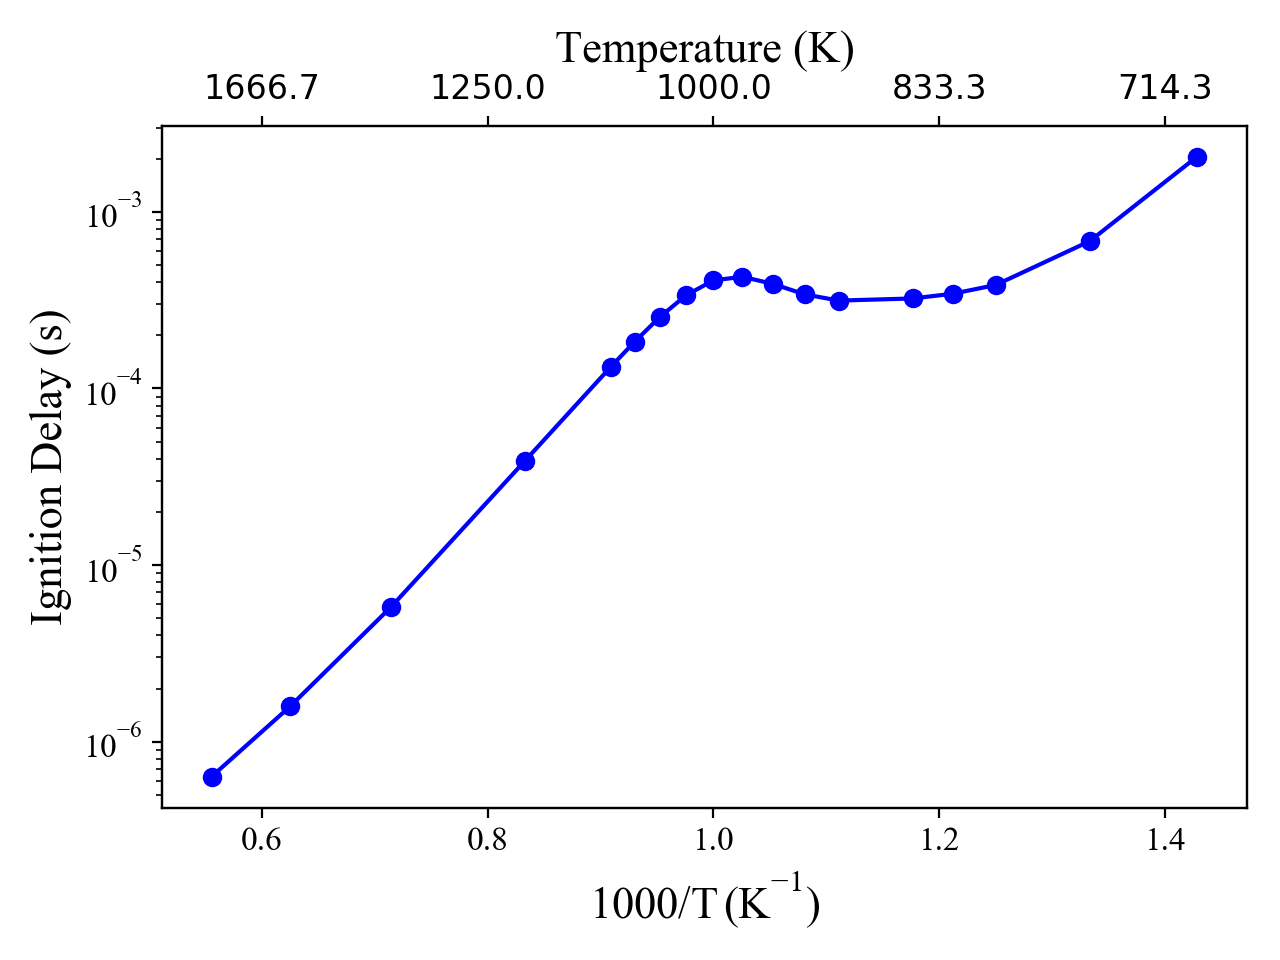

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000/ignitionDelays['T'], ignitionDelays['ignDelay'],'o-',color='b')
ax.set_ylabel('Ignition Delay (s)',fontname='Times New Roman',fontsize=16)
ax.set_xlabel(r'$\mathdefault{1000/T\, (K^{-1})}$', fontsize=16,fontname='Times New Roman')

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000/ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('Temperature (K)',fontname='Times New Roman',fontsize=16);

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
for tick in ax2.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')